In [1]:
import sys

import numpy as np
import torch
from torch import nn
from torch import optim

import tqdm.notebook as tqdm
from IPython.display import HTML

In [2]:
sys.path.append("../")

from bal import data, layers
from utils import animate_skipped_layers

In [3]:
class AdaptiveNet(nn.Module):
    def __init__(self, in_features, h_size, out_features, n_layers):
        super(AdaptiveNet, self).__init__()
        self.n_layers = n_layers
        self.fc1 = nn.Linear(in_features, h_size)
        for i in range(2, self.n_layers):
            setattr(self, f"fc{i}", nn.Linear(h_size, h_size))
            setattr(self, f"skip{i}", layers.SkipConnection(prior_prob=0.9, temperature=1.0))
        setattr(self, f"fc{n_layers}", nn.Linear(h_size, out_features))
        self.lik = layers.GaussianLikelihood(scale=0.1)
        self.bayesian_layers = [getattr(self, f"skip{i}") for i in range(2, self.n_layers)]

    def forward(self, inp):
        out = nn.functional.relu(self.fc1(inp))
        pre = out
        for i in range(2, self.n_layers):
            out = nn.functional.relu(getattr(self, f"fc{i}")(out))
            out = getattr(self, f"skip{i}")(pre, out)
        out = getattr(self, f"fc{self.n_layers}")(out)
        return out

    def log_likelihood(self, xs, ys):
        params = self.forward(xs)
        logprobs = self.lik(params).log_prob(ys)
        return logprobs
    
    def kl_qp(self, n_samples=1, scale=1.0):
        kls = []
        for bl in self.bayesian_layers:
            samples_q = bl.posterior.rsample((n_samples,))
            kls.append(torch.mean(
                bl.posterior.log_prob(samples_q) - bl.prior.log_prob(samples_q)
            ))
        return scale * torch.sum(torch.stack(kls))
        

def geometric_discount(n, i):
    return 2 ** (n - i) / (2 ** n - 1)

In [4]:
def run_step(xs_t, ys_t, opt, net, kl_scale=1.0):
    opt.zero_grad()
    ll = torch.mean(net.log_likelihood(xs_t, ys_t))
    kl = net.kl_qp(n_samples=1, scale=kl_scale)
    loss = kl - ll
    loss.backward()
    opt.step()
    stats = {
        "loss": float(loss.detach().numpy()),
        "skip_probs": [float(torch.sigmoid(l.var_logit.detach()).numpy()) 
                       for l in net.bayesian_layers]
    }
    return stats

In [75]:
domain = (-2.0, 2.0)
xs, ys = data.generate_1d_regression(
    n_points=2000,
    domain=domain, 
    noise_std=0.1,
    seed=7
)
xs_test = np.linspace(-4.0, 4.0, 500).reshape(-1, 1)

In [76]:
MAX_SIZE = 5
MAX_LAYERS = 10
xs_t = torch.as_tensor(xs, dtype=torch.float32)
ys_t = torch.as_tensor(ys, dtype=torch.float32)
xs_test_t = torch.as_tensor(xs_test, dtype=torch.float32)
net = AdaptiveNet(
    in_features=1,
    h_size=MAX_SIZE,
    out_features=1,
    n_layers=MAX_LAYERS
)
opt = optim.Adam(net.parameters(), lr=2e-4)

In [77]:
n_epochs = 120000
batch_size = 2000
pbar = tqdm.tqdm(range(n_epochs))
train_history = {"skip_probs": [], "preds": []}
for i in pbar:
    for j, (x_t, y_t) in enumerate(data.batch_generator(xs_t, ys_t, batch_size, shuffle=True)):
        kl_scale = geometric_discount(len(xs_t) // batch_size, j+1)
        stats = run_step(x_t, y_t, opt, net, kl_scale)
    if i % 300 == 0:
        pbar.set_description_str(
            f"loss: {stats['loss']:4.2f}, " 
            f"skip_probs: {[float(f'{p:3.2f}') for p in stats['skip_probs']]}, "
        )
        train_history["skip_probs"].append(stats["skip_probs"])
        train_history["preds"].append(net(xs_test_t).detach().numpy().squeeze())

for k, v in train_history.items():
    train_history[k] = np.asarray(v)

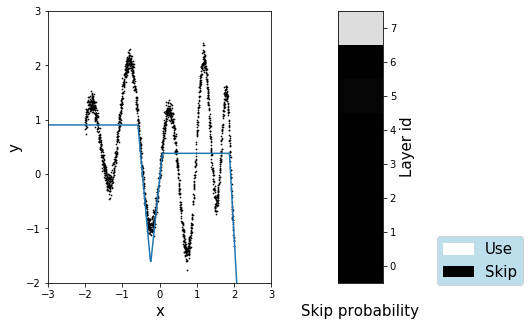

In [79]:
ani = animate_skipped_layers(
    data=(xs, ys), 
    predictions=(xs_test, train_history["preds"]), 
    layer_stats=train_history["skip_probs"], 
    max_size=MAX_SIZE, 
    output_path="../animation"
)
HTML(ani.to_html5_video())